<a href="https://colab.research.google.com/github/cow-coding/ML-DL-Study/blob/master/DL%20from%20Scratch/Book%201/Chap03/5.MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive setting

In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


# Libary import & Setting


In [32]:
from dataset.mnist import load_mnist # load MNIST data
import numpy as np
from PIL import Image                # Image module
from matplotlib.pyplot import imshow
import pickle

%matplotlib inline

# Load MNIST dataset

신경망 학습의 대표적인 예가 손글씨 숫자 분류이다.  
이미 학습된 매개변수를 활용해서 학습은 생략하고 추론과정만 구현할 예정  
이 과정은 **순전파(Forward Propagation)**이라고 한다.

## load_mnist explanation

- parameter
  - normalize : 입력 이미지의 픽셀 0.0 ~ 1.0으로 정규화  
  (False : 0 ~ 255 / True : 0.0 ~ 1.0)  

  - faltten : 입력 이미지 1차원 배열화  
  (False : 1 X 28 X 28의 3차원 배열 / True : 784개의 요소인 1차원 배열)  

  - one_hot_label : label을 0 또는 1의 형태로의 설정 여부  
  (True : 0 or 1 / False : number)

In [49]:
# (train image, train label), (test image, test label)
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False) # one-dimension array & 0~255

# print each data shape
print(x_train.shape)  # (60000, 784)
print(t_train.shape)  # (60000, )
print(x_test.shape)  # (10000, 784)
print(t_test.shape)  # (10000, )

(60000, 784)
(60000,)
(10000, 784)
(10000,)


# Image Show



`flatten`이 `True`이므로 1차원 넘파이 배열이다.  
이미지를 표시할 때는 28 X 28로 변환을 해야하므로 `reshpe()`를 사용한다.  
넘파이 이미지 데이터는 PIL 객처로 변환해야하고 이때 `Image.fromarray()`를 사용함

5
(784,)
(28, 28)


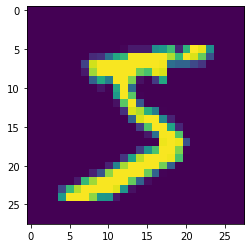

In [21]:
def img_show(img):
  pil_img = Image.fromarray(np.uint8(img))
  imshow(pil_img)

img = x_train[0]
label = t_train[0]
print(label)                # 5

print(img.shape)            # (784, )
img = img.reshape(28, 28)   # reshape for original image shape
print(img.shape)            # (28, 28)

img_show(img)

# Neural Network's Predict

- Input Neuron : 784  
(28 X 28 = 784 Image pixel setting)  

- Output Neuron : 10  
(0 ~ 9 classify setting)

- Hidden Layer : 2 (neuron number is random)
  - First hidden layer : 50 neuron
  - Second hidden layer : 100 neuron

## Activation function & softmax


In [39]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def softmax(x):
  exp_x = np.exp(x)
  sum_exp_x = np.sum(exp_x)

  y = exp_x / sum_exp_x

  return y

## Predict functions

### function explanation

- `init_network()`  
'학습된 가중치 매개변수'를 sample_weight.pkl로부터 가져온다

In [50]:
def get_data():
  (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True, one_hot_label=False)
  
  return x_test, t_test

def init_network():
  with open("ch03/sample_weight.pkl", 'rb') as f:
    network = pickle.load(f)

    return network

def predict(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']

  a1 = np.dot(x, W1) + b1
  z1 = sigmoid(a1)

  a2 = np.dot(z1, W2) + b2
  z2 = sigmoid(a2)

  a3 = np.dot(z2, W3) + b3
  y = softmax(a3)

  return y

## Predict Test

1. x에 저장된 이미지 데이터를 1장식 가져와서 `predict()`로 분류
2. `predict()`에서는 각 label의 확률을 넘파이 배열로 저장 (예 : [0.1, 0.3, ..., 0.04] <- 확률값)
3. `predict()`로 분류된 배열값 중 가장 확률이 높은 원소의 인덱스를 구한다.
4. 해당 인덱스가 예측 결과로 반환

In [51]:
x, t = get_data()
network = init_network()

accuracy_cnt = 0

for i in range(len(x)):
  y = predict(network, x[i])
  p = np.argmax(y) # get index about high percentage elements
  
  if p == t[i]:
    accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


# Batch processing


## Each Layer shape

각 층의 형상 추이를 보면 아래와 같다.  

$
\quad X \quad \quad \ \quad W1 \quad \ \ \quad W2 \quad \ \quad\quad W3 \quad \rightarrow  \ \quad Y \\
1\times784 \quad 784 \times 50 \quad 50 \times 100 \quad 100 \times 10 \quad \quad 1 \times 10
$

위의 과정은 데이터 1장만 입력했을 경우의 흐름이다.  

In [52]:
x, _ = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']

print(x.shape)
print(x[0].shape)
print(W1.shape)
print(W2.shape)
print(W3.shape)

(10000, 784)
(784,)
(784, 50)
(50, 100)
(100, 10)


## Batch

만약 이미지가 여러개 넘겨지는 경우 어떻게 해야할까?  
입력 데이터의 형상을 100개로 늘리면 100장의 데이터가 한 번에 출력된다.  

$
\quad X \quad \quad \quad \quad W1 \quad \ \ \quad W2 \quad \ \quad\quad W3 \quad \rightarrow  \ \quad Y \\
100\times784 \quad 784 \times 50 \quad 50 \times 100 \quad 100 \times 10 \quad \quad 100 \times 10
$  

코드의 흐름으로 보면 `x[0]`와 `y[0]`이 짝을 이루며 결과가 저장된다.  
이렇게 하나로 묶은 입력 데이터를 **배치(Batch)**라고 한다.

## Batch Process implementation

### Code review

1. `x[0:100]`, `x[100:200]`, ...처럼 `batch_size`만큼 데이터를 묶어 꺼내게된다.
2. 앞서 말한 것처럼 `argmax()`의 최댓값 인덱스를 가져온다.  
이때 `axis=1`을 추가해서 x축을 구성하는 원소에서 탐색한다.

In [53]:
x, t = get_data()
network = init_network()

batch_size = 100 # batch size
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
  x_batch = x[i:i + batch_size]
  y_batch = predict(network, x_batch)
  p = np.argmax(y_batch, axis=1)

  accuracy_cnt += np.sum(p == t[i:i + batch_size])

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


### P.S argmax axis

In [56]:
x = np.array([[0.1, 0.8, 0.1],
              [0.3, 0.1, 0.6],
              [0.2, 0.5, 0.3], 
              [0.8, 0.1, 0.1]])

y1 = np.argmax(x, axis=1)
y2 = np.argmax(x, axis=0)
print(y1)
print(y2)

[1 2 1 0]
[3 0 1]
